---
title: Your mission
author: Willie Aboumrad
---

In this challenge you'll implement a hybrid quantum-classical image classification pipeline using `ionqvision`, IonQ's next-generation platform for QML computations, and [`PyTorch`](https://pytorch.org). In particular, you'll train a quantum-classical neural network to distinguish between two types of different handwritten digits in the [MNIST database](wiki:MNIST_database).

:::{hint} Tip

If you haven't used `PyTorch` yet, don't sweat it!

This challenge is about the **quantum** in ["Quantum Machine Learning"](wiki:Quantum_machine_learning). The accompanying [starter code](#sec-training) will set up everything you need, so you can focus on building your best quantum circuits!
:::

The figure below illustrates our hybrid pipeline. The operations inside the gray box make up the *quantum layer*. That's where the magic happens.

:::{figure} media/hybrid_nn.png
:label: fig-hybrid-nn
A diagrammatic representation of our hybrid quantum-classical image classification pipeline
:::

Your mission, should you choose to accept it, is to design the quantum layer that yields the **highest possible classification accuracy** (scored automatically on an unseen validation set). Simple, right?

## Classical, quantum, and then classical again

If you've made it thus far, congratulations! 🎉  

You're about to embark on an exciting journey of quantum discovery. To begin, we'll take a closer look at the architecture of our hybrid neural network. It's important to keep in mind that going through our full *hybrid* pipeline requires **both** classical and quantum hardware, and software that facilitates communication between the two. The `ionqvision` abstracts much of this complexity away and it let's you focus on the quantum design.

In what follows, we'll explain the classical and quantum parts of our pipeline in some detail. Then we'll turn to the [starter code](#sec-training), which will get you up and running in no time!

### Classical pre-processing

The first three layers in our pipeline are purely classical. They implement fairly basic operations commonly encountered in classical image classification pipelines: first flatten each (single-channel) input image, perform dimensionality reduction using [PCA](wiki:Principal_component_analysis), and then embed the compressed images into an even lower-dimensional feature space using a trainable fully-connected layer. We use drop out during training and the sigmoid [activation function](https://en.wikipedia.org/wiki/Activation_function).

:::{image} media/classical_pre.png
:width: 75%
:::

:::{warning} Note 

This part of the architecture is essentially **fixed**: the only thing you get to decide here is the dimension $n$ of the resulting latent vectors. For instance, in [](#fig-hybrid-nn), $n = 12$.
:::

(sec-quantum-layer)=
### Quantum Layer

Then comes the most interesting part: the "quantum layer." Our whole challenge revolves around this layer: the best design here will achieve the highest classification accuracy. And there's a **big prize** for that. 🥇

The quantum layer consists of three components:

1. an encoding circuit used to load each $n$-dimensional latent vector into an $n$-dimensional qubit state,
2. a variational circuit on $n$ qubits with trainable parameters used to learn how to separate encoded latent vectors in the high-dimensional multi-qubit state space, and
3. a list of $m$ measureable quantities used to extract "quantum features" from the transformed $n$-qubit states for classification. (For instance, $m = 4$ in [](#fig-hybrid-nn).)

:::{image} media/quantum_layer.png
:width: 75%
:::

To get the ball rolling, look to the `ionqvision.ansatze.ansatz_library` module for inpiration. We've implemented some of the encoders and ansatze commonly encountered in the literature.

For instance, you could use the `AngleEncoder`, which has the following structure, for your first model.

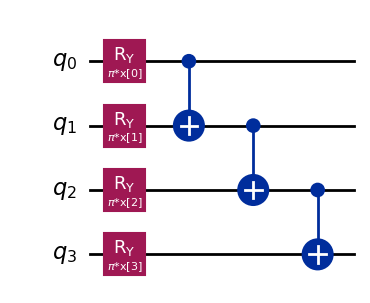

In [1]:
from ionqvision.ansatze.ansatz_library import AngleEncoder

encoder = AngleEncoder(num_qubits=4)
encoder.draw("mpl")

In addition, you can use its implementation as a **template** for your novel encoder designs!

:::{literalinclude} ../ionqvision/ionqvision/ansatze/ansatz_library.py
:start-line: 18
:end-line: 56
:lineno-match:
:::

Similarly, you can leverage the built-in `BrickworkLayoutAnsatz`, or the `QCNNAnsatz`, amongst others, for the trainable layer. 

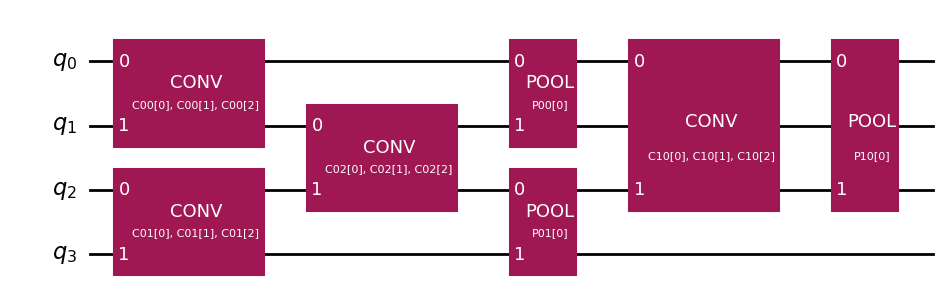

In [2]:
from ionqvision.ansatze.ansatz_library import QCNNAnsatz

ansatz = QCNNAnsatz(num_qubits=4)
ansatz.draw("mpl")

This ansatz is particularly interesting as it consists of a sequence of “convolution” filters interspersed with pooling operations that reduce the number of “active” qubits upon each layer. Note that our implemenation modifies the [original design](https://www.nature.com/articles/s41567-019-0648-8) by replacing the mid-circuit measurements with controlled rotations.

If you'd like to try out this ansatz, be sure to [subclass](https://pybit.es/articles/python-subclasses/) and implement your own `QCNNAnsatz.ConvolutionBrickwork` and `QCNN.PoolingLayer` modules!

:::{literalinclude} ../ionqvision/ionqvision/ansatze/ansatz_library.py
:start-line: 270
:end-line: 329
:lineno-match:
:::

While `ionqvision` does not provide built-in qubit observables, you can set these up using `qiskit` as follows.

In [3]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of X_0, Y_0, Z_0
quantum_features = [
    SparsePauliOp(["IIIX"]), 
    SparsePauliOp(["IIIY"]), 
    SparsePauliOp(["IIIZ"])
]

It's important to keep in mind that the encoder, the ansatz, and the quantum feature vector are highly interrelated: the way you embed latent vectors into (multi-)qubit state space should dictate how you choose to transform the encoded state vectors, which should in turn inform what features you decide to measure.

The best model will likely exploit synergies resulting from intentional co-design of the three components.

:::{important}

This is where you should let your imagination run free! Get creative, and show us what you've got. Feel free to leverage the power of the internet and use every resource at your disposal.
:::

### Classical post-processing

After the quantum layer, feature vectors in the classification pipeline return to the classical device for some post-processing. In particular, we train a fully-connected layer with a scalar output to minimize the binary [cross-entropy](wiki:Cross-entropy) between the final value and the input image's true label. Again, we use drop out during training and the sigmoid [activation function](https://en.wikipedia.org/wiki/Activation_function).

:::{image} media/classical_post.png
:width: 45%
:::

This final stage is intentionally light, to ensure the quantum layer is the star of the show.

:::{warning} Note

This part of the architecture is totally **fixed**: the input dimension ($m$) is determined by the quantum feature vector, and the output is always a scalar.
:::

(sec-training)=
## Training your model

Once you've settled on your quantum layer, you can sit back, relax, and let `ionqvision` do the heavy lifting. First, set up your classifier and verify it's working as expected.

In [4]:
from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features); classifier

BinaryMNISTClassifier(
  (latent_vec_encoder): Sequential(
    (0): Linear(in_features=168, out_features=4, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
  (quantum_layer): QuantumModule()
  (prediction_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
)

In case you're wondering, `BinaryMNISTClassifier` is a standard `torch.nn.Module`; at this point, all the parameters in your quantum layer have been registered with `torch` and the `autograd` will automatically compute the relevant gradients during the backward pass. Nothing else to worry about!

Be sure to checkout the [IonQ Vision Docs](https://refactored-adventure-228m4r2.pages.github.io/ionqvision-docs/) to learn more about the inner workings of the `BinaryMNISTClassifier` and all the related classes. The {kbd}`IonQ Vision Docs` button at the top-right corner of the page links directly to the API refrence.

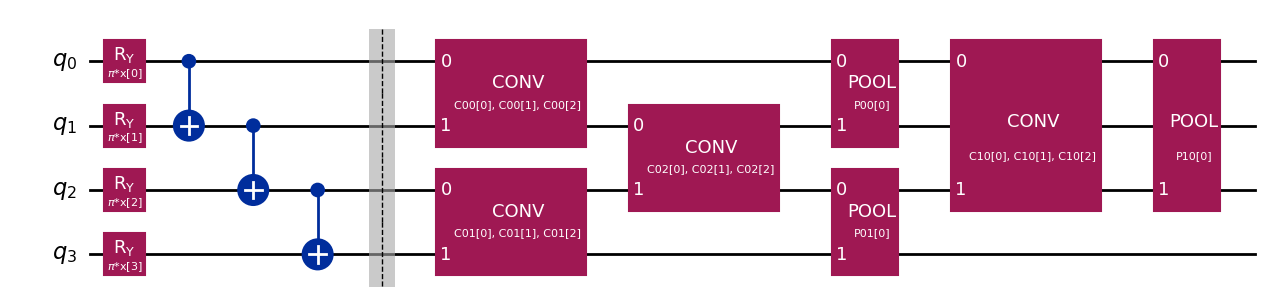

In [5]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


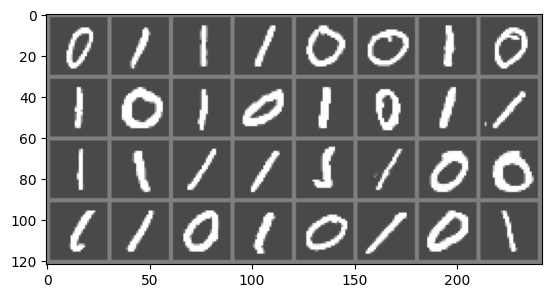

In [6]:
# Verify the images loaded correctly
classifier.visualize_batch()

Now train your model. Use the `config` dictionary to control lower-level aspects of the training, like the number of `epochs`, the learning rate, the `betas` used by [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), etc.

epoch:   1 | loss: 0.714
lr: 0.1000 | processed     6/    6 batches per epoch in 140.31s (0.76s forward / 21.37s backward)
Model achieved 54.667%  accuracy on TRAIN set.
Model achieved 53.000%  accuracy on TEST set.

epoch:   2 | loss: 0.698
lr: 0.1000 | processed     6/    6 batches per epoch in 140.33s (0.78s forward / 21.67s backward)
Model achieved 45.333%  accuracy on TRAIN set.
Model achieved 47.000%  accuracy on TEST set.

epoch:   3 | loss: 0.690
lr: 0.1000 | processed     6/    6 batches per epoch in 140.98s (0.80s forward / 22.25s backward)
Model achieved 65.000%  accuracy on TRAIN set.
Model achieved 57.000%  accuracy on TEST set.

epoch:   4 | loss: 0.695
lr: 0.1000 | processed     6/    6 batches per epoch in 139.55s (0.74s forward / 21.01s backward)
Model achieved 66.000%  accuracy on TRAIN set.
Model achieved 61.000%  accuracy on TEST set.



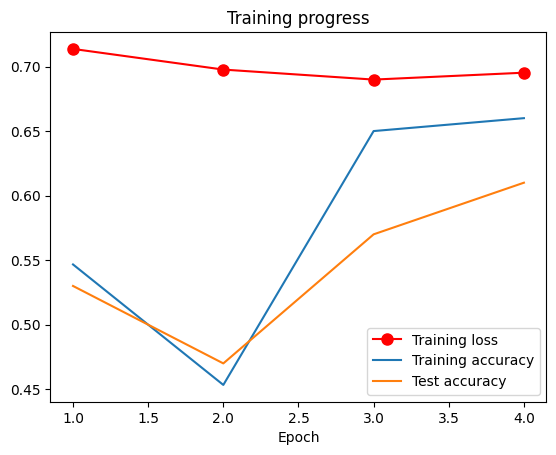

In [7]:
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=300, test_size=100)

# Configure model training hyper parameters
config = {
    "epochs": 4,
    "lr": 0.1,
    "batch_size": 50,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 6,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

The model achieved {eval}`f"{100*classifier.train_acc[-1]:.02f}%"` on the **training** set and {eval}`f"{100*classifier.test_acc[-1]:.02f}%"` on the **test** set.

### Submitting your model for grading

Now comes the final thrill. Use your `classifier`'s `submit_model_for_grading` method to, well, submit your model for grading!

Your quantum layer and your model's trained weights will be serialized and then reconstructed in a sanitized environment. We'll run inference using the reconstructed model on an unseen validation set to compute your accuracy score.

Be sure to check our live leader board after a few minutes to see where your team stands!

::::::{warning}

Make sure you've created your team branch, e.g., using `git checkout -b my-team-name` before running the following command.

:::{seealso}
Check out our [setup instructions](#ch-env-setup) and our [tips and tricks section](#ch-tips-tricks) for more [details](#block-team-branch).
:::

In addition, the following command assumes your current directory is the **root** of the cloned challenge repo (`ionq-skku-vision-challenge`). Check out the [documentation](https://refactored-adventure-228m4r2.pages.github.io/ionqvision-docs/modules.html#ionqvision.modules.binary_classifier.BinaryMNISTClassifier.save_model) of the optional `path_to_repo` parameter to work in a different directory.
::::::

In [9]:
classifier.submit_model_for_grading()

Success! Submitted trained_models/model_e5e7ca05465cd7b5661959c722b92a7ac291834d.zip for grading!


::::::{note}
The `submit_model_for_grading` method prepares an archive containing your trained model's weights, and everything that's needed to rebuild your quantum layer. The archive is stored in the `trained_models` directory in your copy of our repository.

:::{caution}

Don't change the archive's name or its contents.
:::
::::::

Good luck now! We hope you enjoy this exciting challenge.